In [121]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/clean_psyphysical_main1.csv")

#Create unique players
df["player_nb"] = "p" + df["player"].astype(str)
df["player"] = df["player"].astype(str)
df["player"] = df["player"] + df["participant_code"]

#Combine session code with mastok session
df["mk_session"] = df["mk_session"].replace('mk:psyphysical_main:', 'mk_', regex=True)
df["mk_session"] = df["mk_session"] + "_" + df["session_code"]
df = df.loc[df["participant_code"] != "upmsjgar"] #excluding player 5 (Pablo)

#Other manipulation variable for interpretation reasons
df["other_manipulation"] = np.where(df["manipulation"] == "submissive", "dominant", "submissive")

#Changed answer between before and after interaction
df["changed_answer"] = df["indv_response"] != df["group_choice"]

#Difference in confidence between before and after interaction - negative values indicates higher confidence
#post interaction.
df["conf_change"] = df["confidence_1"] - df["confidence_2"]

speech_data = pd.read_csv("../data/speech_data.csv")
df = df.merge(speech_data[['player_nb', 'round_nb', 'speech_onset']], on=['player_nb', 'round_nb'], how='left')


##### Creating some other useful variables

In [122]:
for index,row in df.iterrows():
    round_nb = row["round_nb"]
    player = row["player_nb"]
    dyad = row["dyad"]
    other_player = dyad.replace(player, "")
    if other_player == "p5":
        continue

    other_index = df[(df['round_nb'] == round_nb) & (df['player_nb'] == other_player)].index
    other_onset = df.loc[other_index, "speech_onset"].values[0]
    onset_diff  = abs(row["speech_onset"] - other_onset)
    
    if pd.isna(onset_diff):
        spoke_first = np.nan
    else:
        spoke_first = row["speech_onset"] < other_onset

    df.loc[index, 'onset_diff'] = onset_diff 
    df.loc[index, 'spoke_first'] = spoke_first


    #dyad conf difference
    other_conf = df.loc[other_index, "confidence_1"].values[0]
    conf_diff1 = abs(row["confidence_1"] - other_conf)
    other_conf = df.loc[other_index, "confidence_2"].values[0]
    conf_diff2 = abs(row["confidence_2"] - other_conf)
    df.loc[index, 'dyad_conf_diff1'] = conf_diff1
    df.loc[index, 'dyad_conf_diff2'] = conf_diff2


C:\Users\dazaz\AppData\Local\Temp\ipykernel_7668\1637802294.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'spoke_first'] = spoke_first


## Confidence Measures

Text(0.5, 1.0, 'Confidence 2')

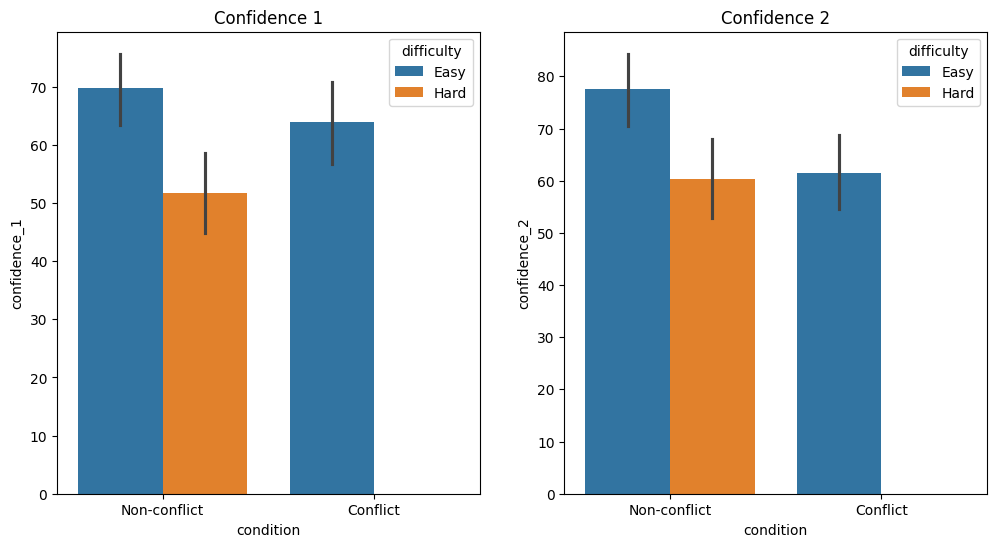

In [69]:
df_analysis1 = df.groupby(["condition", "difficulty", "player"])["confidence_1"].mean().reset_index()
df_analysis2 = df.groupby(["condition", "difficulty", "player"])["confidence_2"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x="condition", y="confidence_1", hue="difficulty", data=df, ax=axes[0])
axes[0].set_title('Confidence 1')
sns.barplot(x="condition", y="confidence_2", hue="difficulty", data=df, ax=axes[1])
axes[1].set_title('Confidence 2')

#These plots show that confidence is lower for hard trials, and that condidence is lower post-interaction in conflict trials. 
#It also shows a slight uptick between pre and post-interaction for both difficulties in non-conflict conditions.

Text(0.5, 1.0, '')

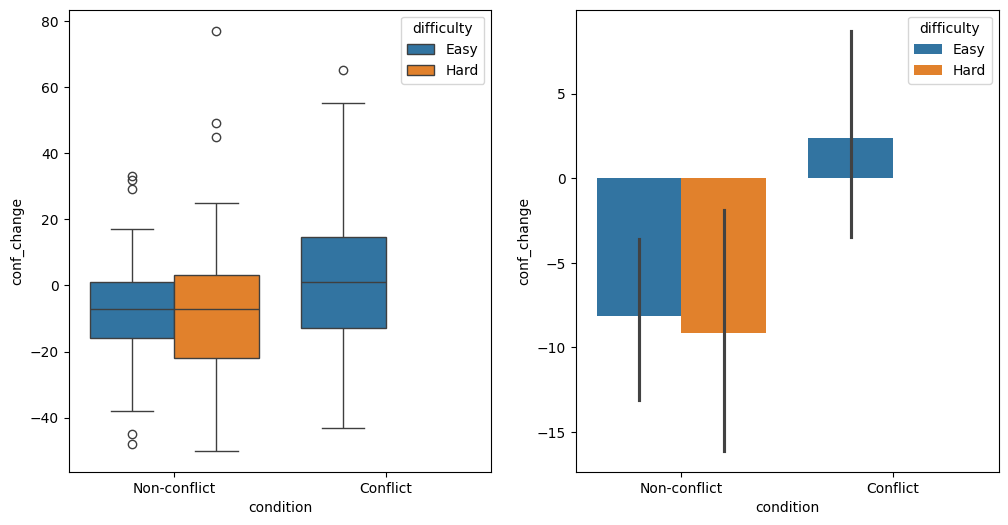

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x="condition", y="conf_change", hue="difficulty", data=df, ax=axes[1])
axes[0].set_title('')
sns.boxplot(x="condition", y="conf_change", hue="difficulty", data=df, ax=axes[0])
axes[1].set_title('')

#To get a more clear picture of what is happening to the confidence rating as a result of the interaction we look at the conf_difference variable. 

#Looking at non-conflict trials, we can see that one tends to increase confidence after interaction, independent of difficulty. 
#Conversely, for conflict trials one tends to have a lower confidence afterh the interaction. 


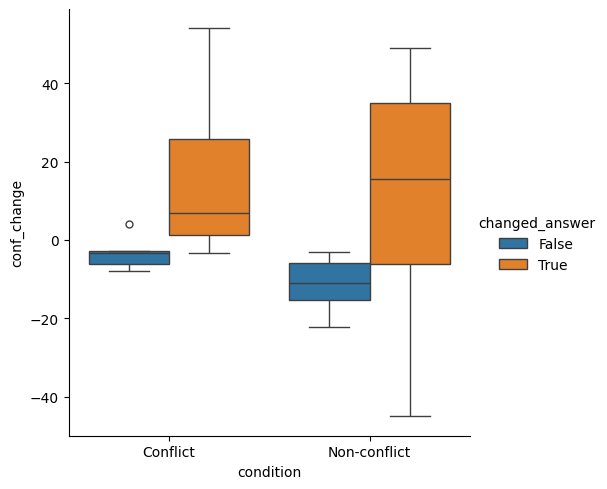

In [71]:
#Another thing we would expect is for the confidence to drop significantly if the participant changes his answer, i.e. cases where his group choice is opposite
#of his individual choice made previously. 

df_analysis = df.groupby(["changed_answer", "condition", "difficulty", "player"])["conf_change"].mean().reset_index()
sns.catplot(x = "condition", y="conf_change", kind="box", data=df_analysis, hue="changed_answer")

#And this appears to be true for both conditions, although the error bars are uge for non-conflcit conditions. 

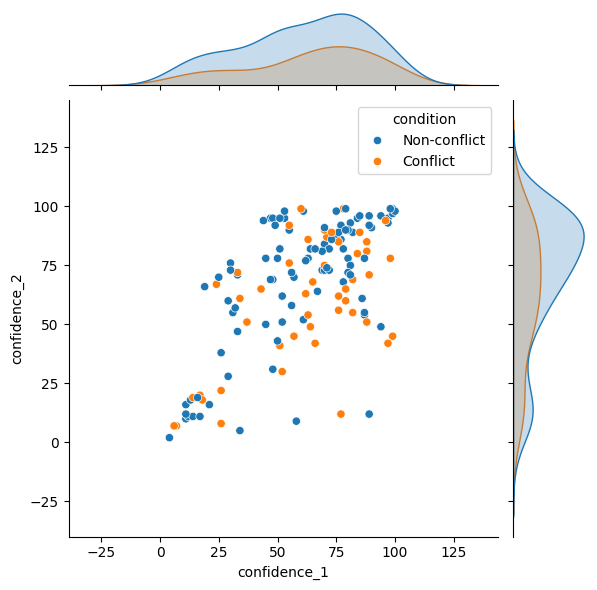

In [72]:
sns.jointplot(data=df, x = "confidence_1", y="confidence_2", hue="condition")

### Effects of voice manipulation

<Axes: xlabel='condition', ylabel='abs_conf_change'>

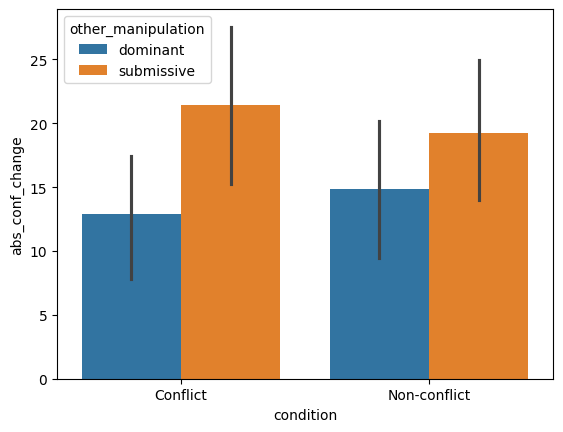

In [73]:
#Lets start by looking at the absolute changes in confidence in response to voice manipulation.
df["abs_conf_change"] = abs(df["confidence_1"] - df["confidence_2"])

df_analysis = df.groupby(["other_manipulation", "condition", "difficulty", "player"])["abs_conf_change"].mean().reset_index()
sns.barplot(x="condition", y="abs_conf_change", hue="other_manipulation", data=df_analysis)

#These plots indicate that when the other person has a submissive voice, you tend to change your confidence more after the interaction.
#This holds true both in conflict and non-conflict trials, altough the effect seems a bit stronger in conflict trials. 
#Overall this indicates that the submissive manipulation has more of an effect on confidence. 


#### Conflict trials

Text(0.5, 1.0, 'bar')

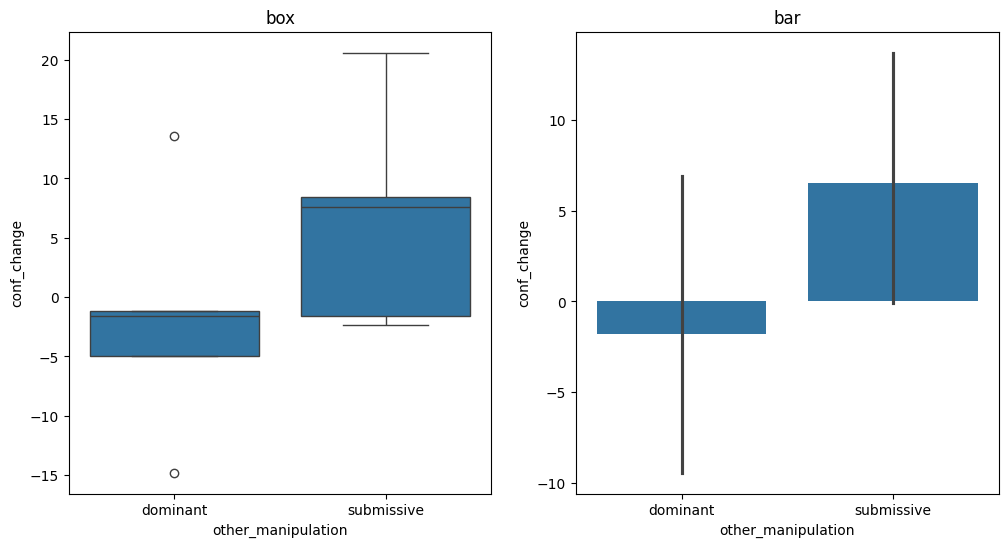

In [74]:
#Lets look only at conflict trials now. 
conflict_trials = df[df["condition"] == "Conflict"]

df_analysis = conflict_trials.groupby(["other_manipulation", "player"])["conf_change"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x="other_manipulation", y="conf_change", data=df_analysis, ax=axes[0])
axes[0].set_title('box')
sns.barplot(x="other_manipulation", y="conf_change", data=df_analysis, ax=axes[1])
axes[1].set_title('bar')

#According to these plots, there is a tendency to be less certain of your choice after being subject to a submissive voice during the interaction, as compared to a dominant one. 
#RECALL THAT THESE ARE CONFLICT TRIALS!

<Axes: xlabel='changed_answer', ylabel='conf_change'>

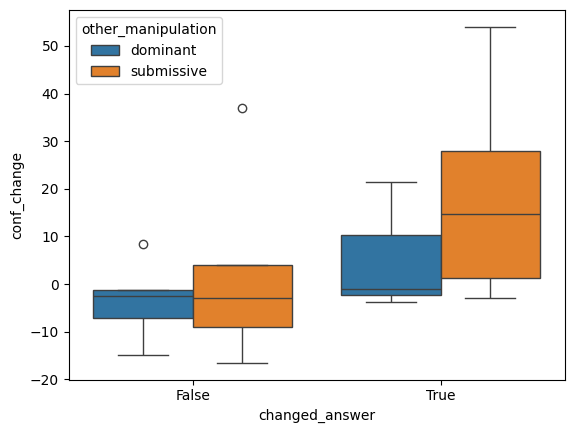

In [105]:

df_analysis = conflict_trials.groupby(["changed_answer", "other_manipulation", "player"])["conf_change"].mean().reset_index()
sns.boxplot(x="changed_answer", y="conf_change", data=df_analysis, hue ="other_manipulation")

Text(0.5, 1.0, 'conf_2')

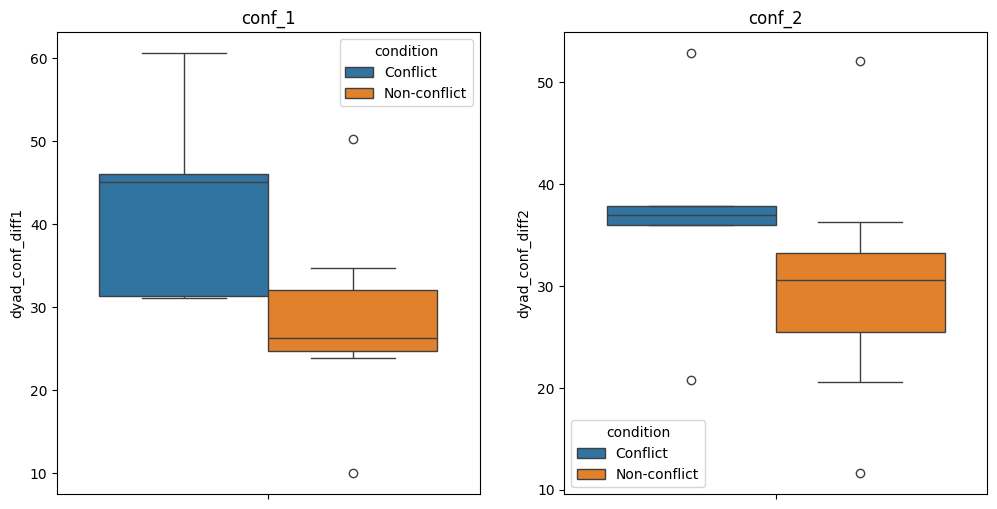

In [134]:


df_analysis1 = df.groupby(["condition", "difficulty", "player"])["dyad_conf_diff1"].mean().reset_index()
df_analysis2 = df.groupby(["condition", "difficulty", "player"])["dyad_conf_diff2"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y = "dyad_conf_diff1", hue = "condition", data = df_analysis1, ax=axes[0])
axes[0].set_title('conf_1')
sns.boxplot(y = "dyad_conf_diff2", hue = "condition", data = df_analysis2, ax=axes[1])
axes[1].set_title('conf_2')

## Probability of changing answer

In [76]:
#Lets begin by excluding trials where the participant failed to give an individual response and where the group did not reach an agreement. 
df_responded = df.dropna(subset=["indv_response"])
df_responded = df[df["both_agree"] != 0]

# Convert "True"/"False" strings to boolean values
df_responded["indv_responded_correctly"] = df_responded["indv_responded_correctly"].map({"True": True, "False": False})
print(df_responded["indv_responded_correctly"].mean())

0.9448275862068966


C:\Users\dazaz\AppData\Local\Temp\ipykernel_7668\442686546.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_responded["indv_responded_correctly"] = df_responded["indv_responded_correctly"].map({"True": True, "False": False})


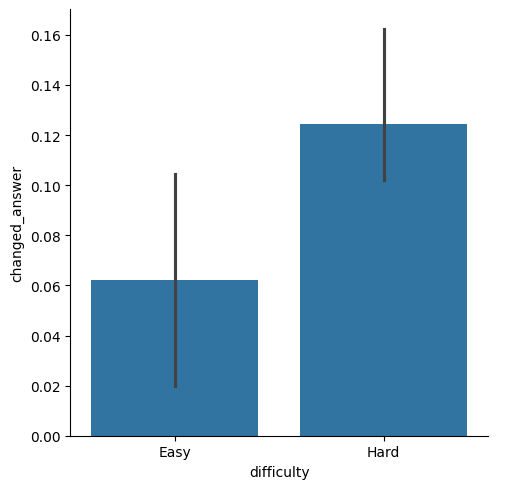

In [77]:
#Lets start by looking at whether you are more likely to change answer for hard trials in non-conflict. In conflict trials we know it will be 50% since half of the participants are 
#forced to change answer in each trial.
NC_responded = df_responded[df_responded["condition"] == "Non-conflict"]
df_analysis = NC_responded.groupby(["condition", "difficulty", "player"])["changed_answer"].mean().reset_index()
sns.catplot(x = "difficulty", y = "changed_answer", data=df_analysis, kind="bar")

#So a little bit more likely to change answer if the trial is Hard. 

### Effects of manipulation

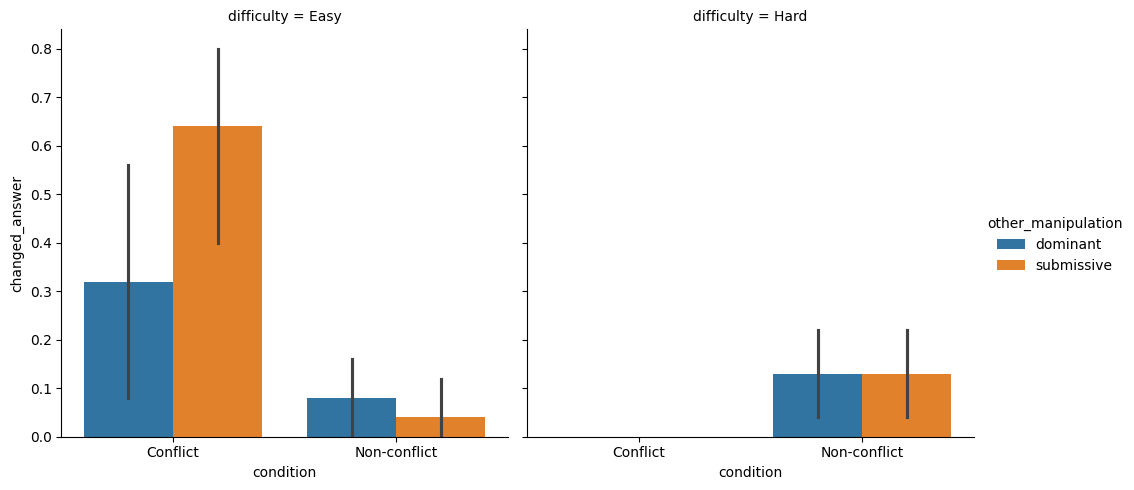

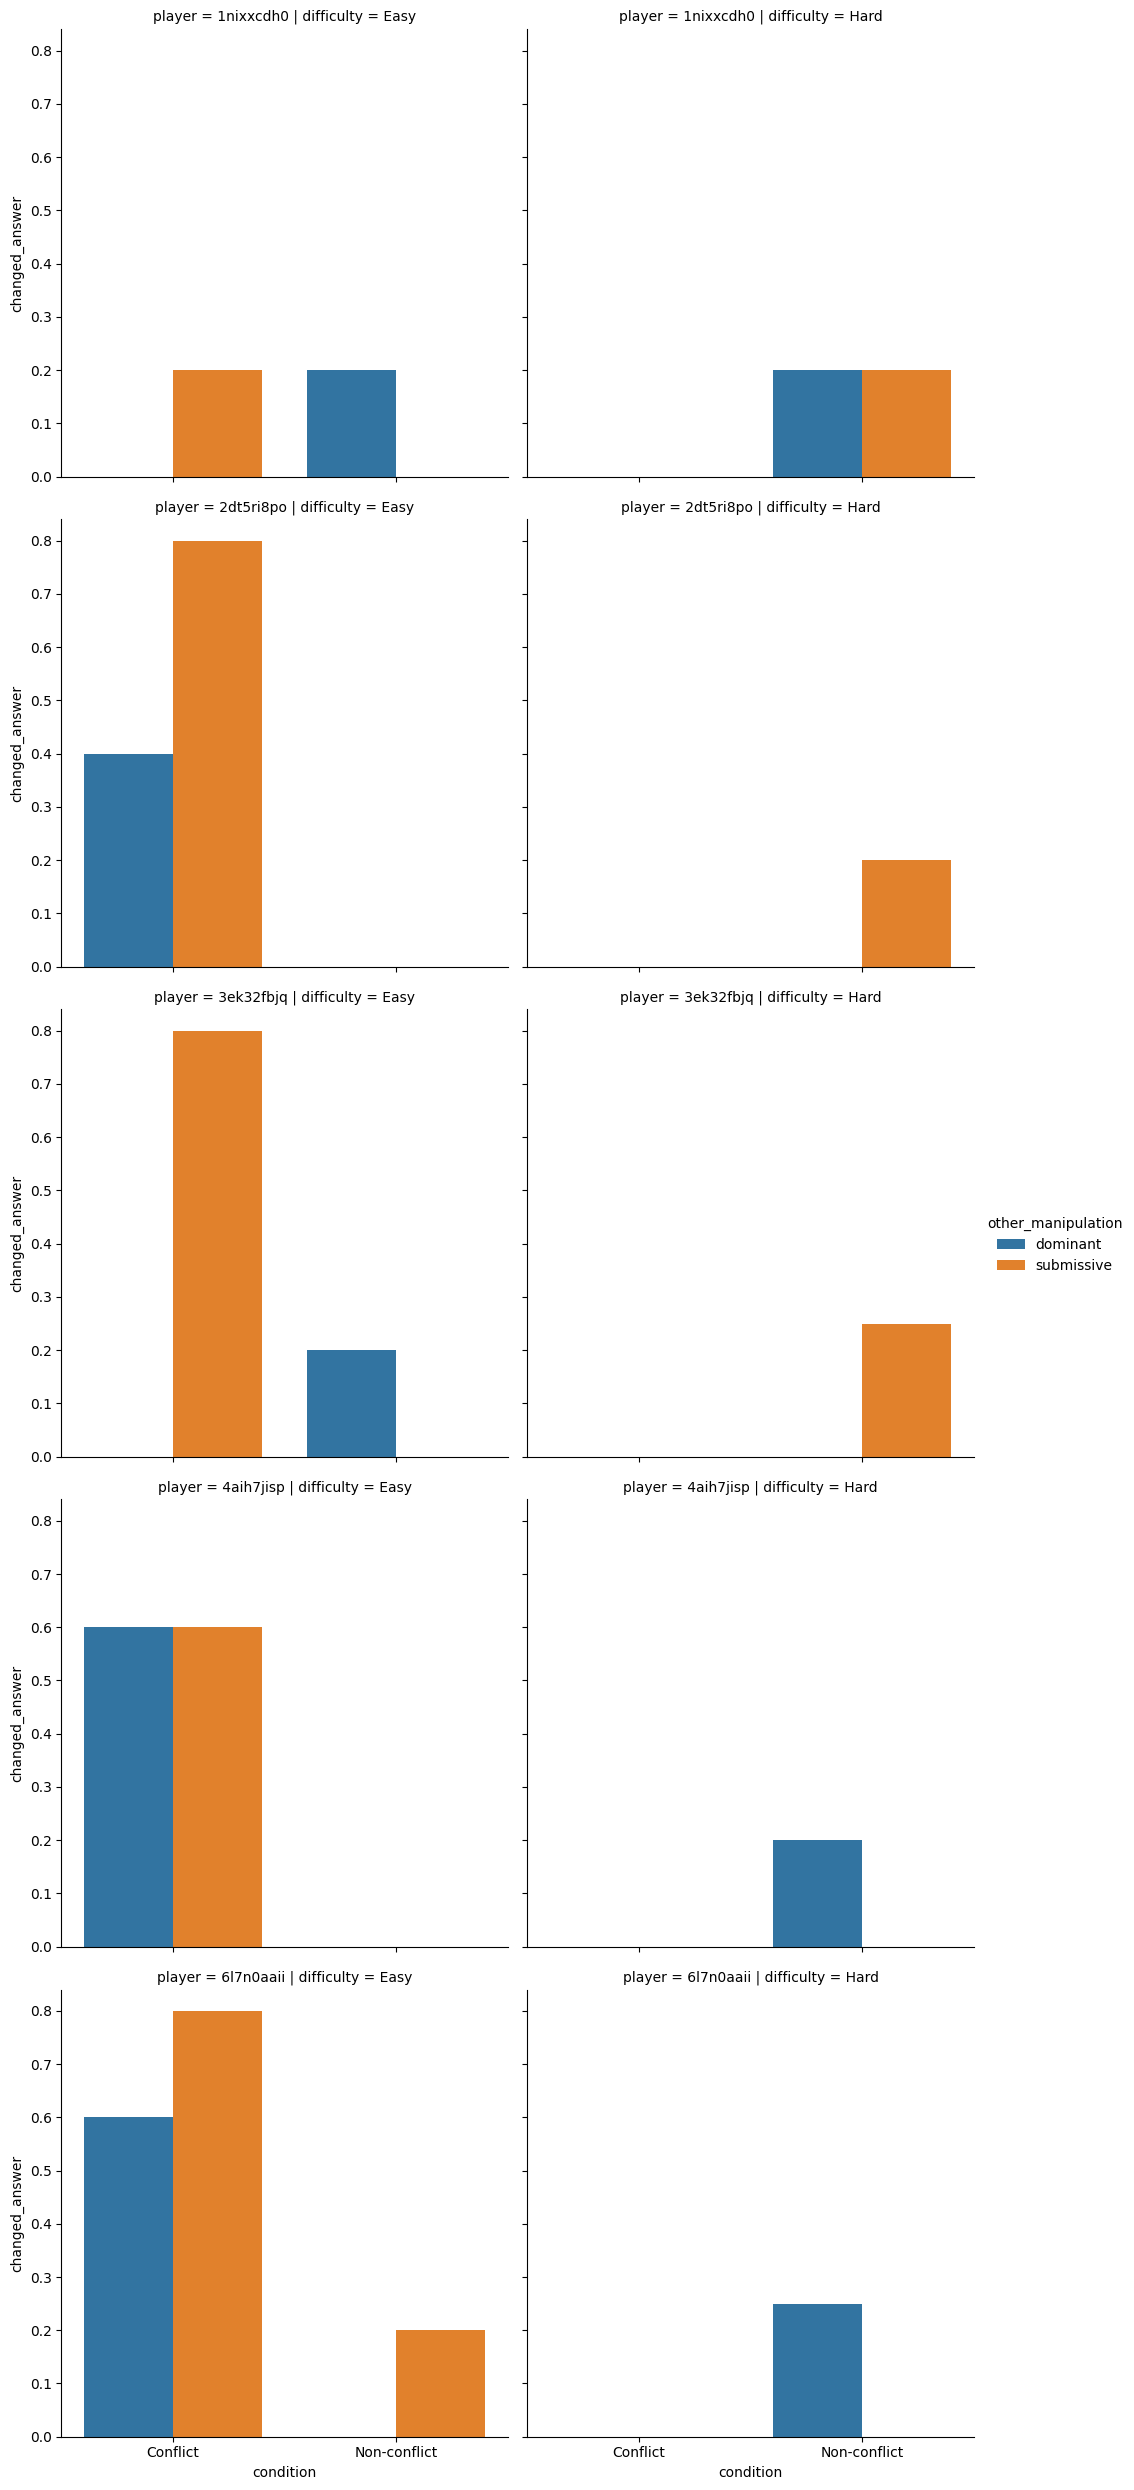

In [78]:
df_analysis = df_responded.groupby(["condition", "other_manipulation", "difficulty", "player"])["changed_answer"].mean().reset_index()
sns.catplot(x = "condition", y="changed_answer", hue="other_manipulation", col = "difficulty", data=df_analysis, kind="bar")

#This plot indicates that there is not effect of manipulation in non-conflict trials, but we know from audio recordings that in many of these trials there was no interaction since
#they both agree super fast and move on. 

#However, in conflict trials, it appears that it is more likely for a participant to follow a submissive voice than a dominant voice. 

sns.catplot(x = "condition", y="changed_answer", hue="other_manipulation", col = "difficulty", row = "player", data=df_analysis, kind="bar")

### Reaction time

2217.787755102041


<Axes: xlabel='rt_individual', ylabel='Density'>

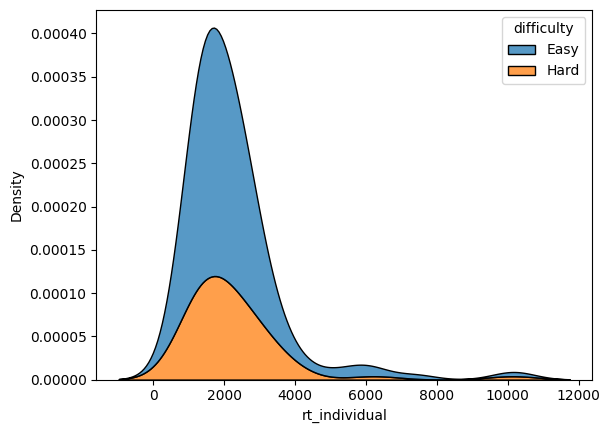

In [79]:
print(df_responded["rt_individual"].mean())

sns.kdeplot(x="rt_individual",multiple="stack", data=df_responded, hue="difficulty")

#MEAN = 2.2 seconds

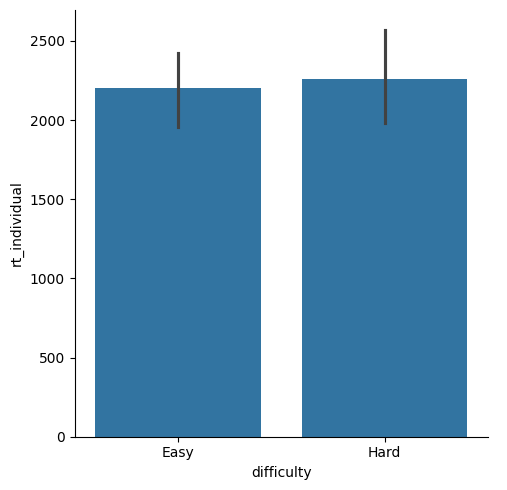

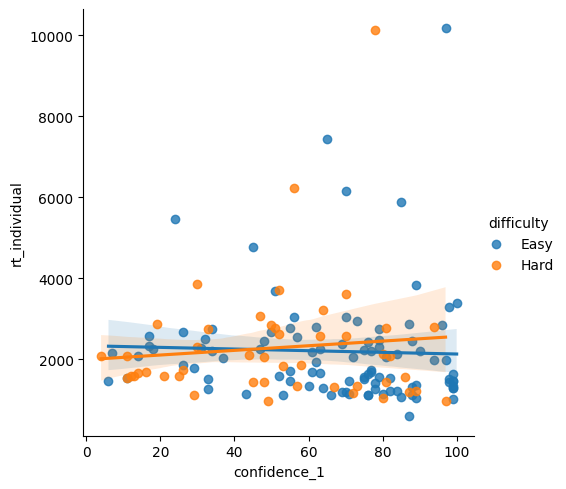

In [80]:
df_analysis = df_responded.groupby(["condition", "difficulty", "player"])["rt_individual"].mean().reset_index()
sns.catplot(x="difficulty", y="rt_individual", data=df_analysis, kind="bar")
sns.lmplot(x="confidence_1", y="rt_individual", data=df_responded, hue="difficulty")

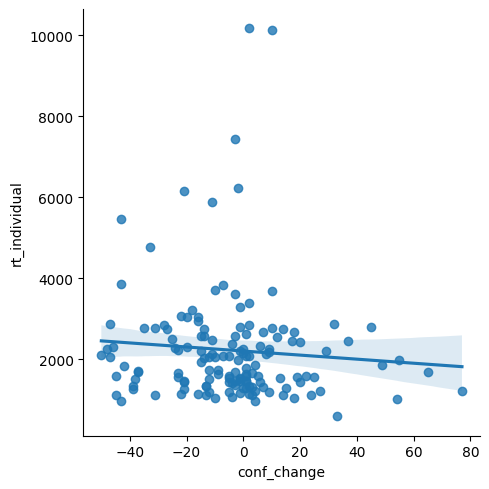

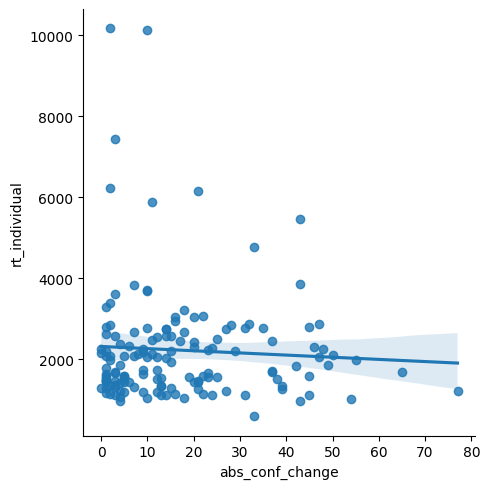

In [110]:
sns.lmplot(x="conf_change", y="rt_individual", data=df_responded)
sns.lmplot(x="abs_conf_change", y="rt_individual", data=df_responded)

#### Group rt

4884.792517006803


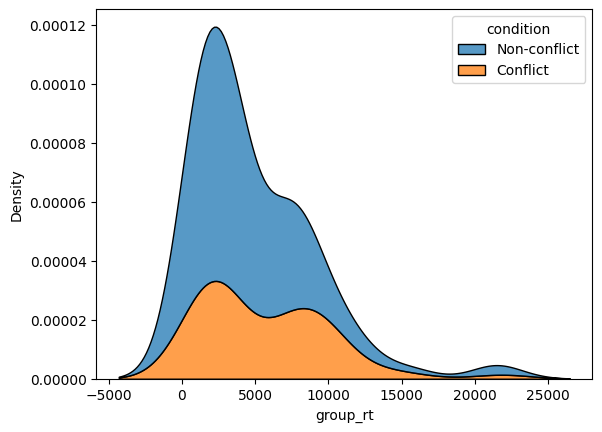

In [81]:
sns.kdeplot(x="group_rt",multiple="stack", data=df_responded, hue="condition")
print(df_responded["group_rt"].mean())

#mean = 4.8 seconds

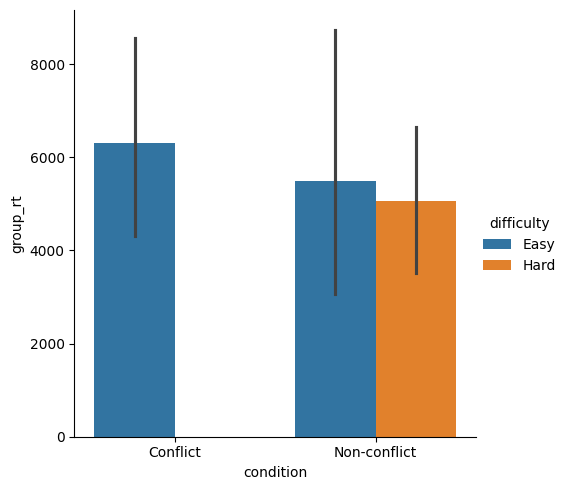

In [82]:
df_analysis = df_responded.groupby(["condition", "difficulty", "dyad"])["group_rt"].mean().reset_index()
sns.catplot(x = "condition", y="group_rt", hue="difficulty", data=df_analysis, kind="bar")

### Speech onset

<Axes: xlabel='speech_onset', ylabel='Density'>

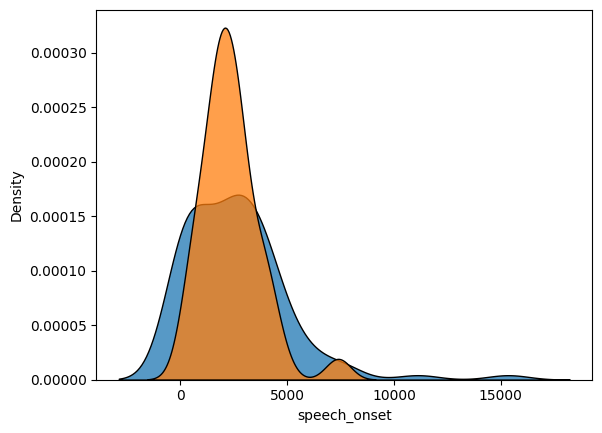

In [83]:
sns.kdeplot(x="speech_onset",multiple="stack", data=df)
sns.kdeplot(x="onset_diff",multiple="stack", data=df)

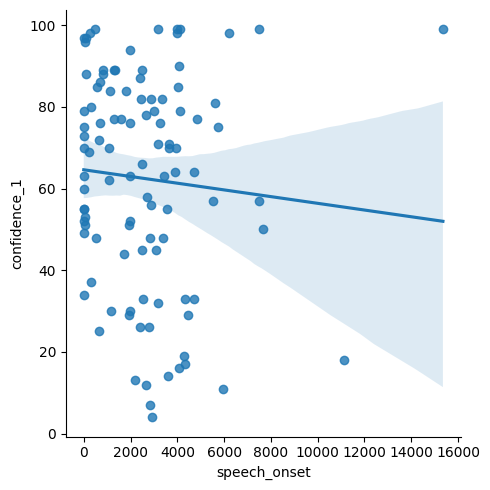

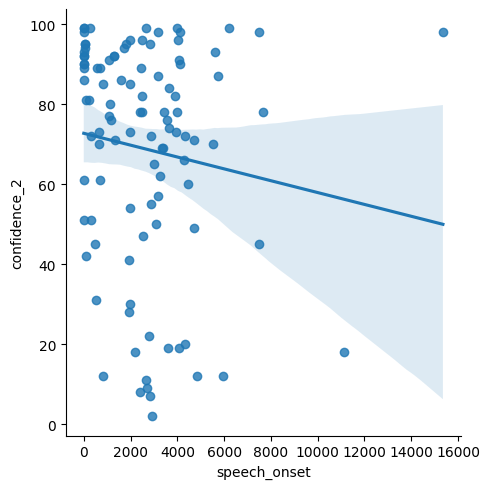

In [84]:
sns.lmplot(x="speech_onset", y="confidence_1", data=df)
sns.lmplot(x="speech_onset", y="confidence_2", data=df)

Text(0.5, 1.0, 'conf_2')

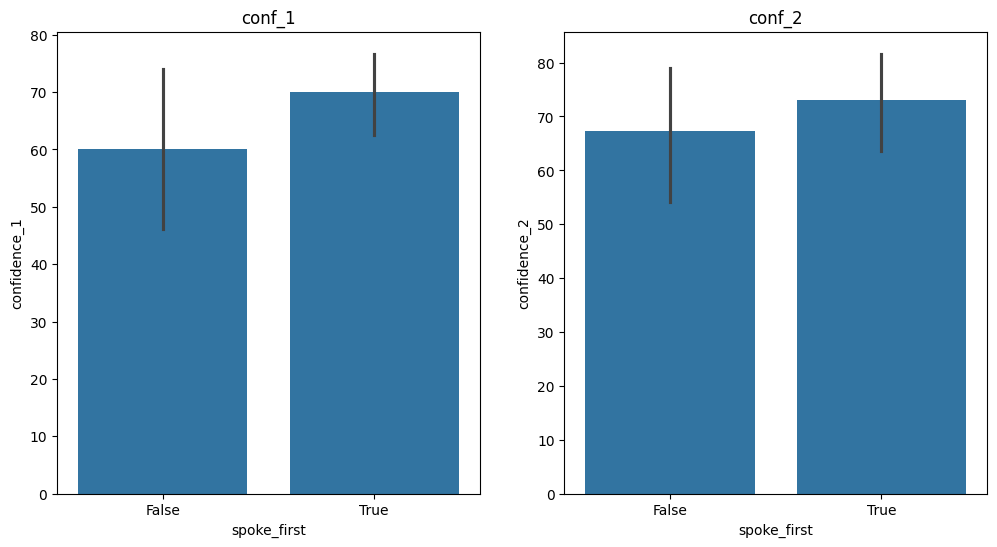

In [96]:
df_analysis1 = df_responded.groupby(["condition", "difficulty", "player","spoke_first"])["confidence_1"].mean().reset_index()
df_analysis2 = df_responded.groupby(["condition", "difficulty", "player","spoke_first"])["confidence_2"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x = "spoke_first", y = "confidence_1", data = df_analysis1, ax=axes[0])
axes[0].set_title('conf_1')
sns.barplot(x = "spoke_first", y = "confidence_2", data = df_analysis2, ax=axes[1])
axes[1].set_title('conf_2')

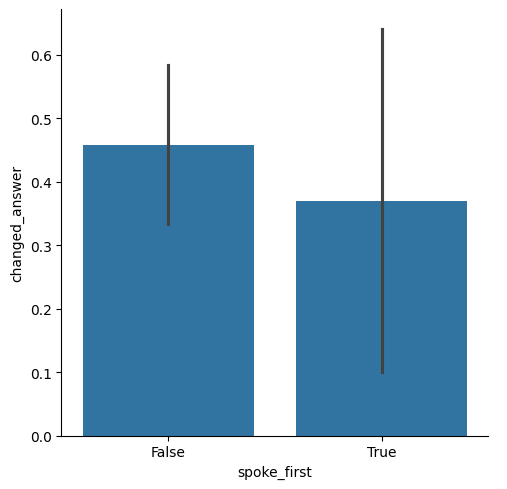

In [106]:
df_analysis = conflict_trials.groupby(["condition", "difficulty", "player","spoke_first"])["changed_answer"].mean().reset_index()
sns.catplot(x = "spoke_first", y = "changed_answer", data = df_analysis, kind = "bar")